# Analyzing Residential Properties in Ames, Iowa

## Imports and Load Data

In [31]:
#Imports
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Flatten
# import tensorflow.keras.backend as K
# from keras.layers import Dropout
# from keras.layers import Dense
# from keras.optimizers import Adam
# from keras import regularizers
from xgboost import XGBRegressor
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [32]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [33]:
# The original dataset on the Kaggle is divided into train and test set, we combine two dataset and split afterward in our way.
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])

## Clean Data

In [34]:
# From the data description, when these values are nan, the property does not contain installment. 
# So we will change these features from nan to None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [35]:
# Check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [36]:
def clean_df(df):
    
    for col in df.columns:
        
        # Replace the missing value to None if feature is in the na_none list
        if col in na_none:
            df[col] =  df[col].fillna('None')
        
        # Drop features that contain more than 20% missing values
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
            
    return df

In [37]:
df_cleaned = clean_df(df_raw) # drop columns and replace nan with none

df_cleaned = df_cleaned.dropna() #drop any row with missing data

In [38]:
#Drop ID column
df_cleaned = df_cleaned.drop('Id', axis=1)

# split train dataset
df_x = df_cleaned.drop(columns='SalePrice')
df_y = df_cleaned['SalePrice']

df_x.shape

(2726, 78)

In [39]:
df_cleaned

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,2,2008,WD,Normal,208500.000000
1,20,RL,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,5,2007,WD,Normal,181500.000000
2,60,RL,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2008,WD,Normal,223500.000000
3,70,RL,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,...,0,None,None,None,0,2,2006,WD,Abnorml,140000.000000
4,60,RL,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,...,0,None,None,None,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,RL,13384,Pave,None,Reg,Lvl,AllPub,Inside,Mod,...,0,None,None,None,0,5,2006,WD,Normal,188506.431412
1452,160,RM,1533,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,12,2006,WD,Abnorml,172917.456816
1455,160,RM,1894,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,4,2006,WD,Abnorml,164788.778231
1456,20,RL,20000,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,...,0,None,None,None,0,9,2006,WD,Abnorml,219222.423400


## Encode Data

In [40]:
#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [41]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

In [42]:
df_x_encoded

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,188216.590793,8450,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,2,2008,178231.141232,178717.795783
1,20,188216.590793,9600,1,1,1,1,1,181436.760833,1,...,0,0,1,1,1,0,5,2007,178231.141232,178717.795783
2,60,188216.590793,11250,1,1,2,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2008,178231.141232,178717.795783
3,70,188216.590793,9550,1,1,2,1,1,182996.979724,1,...,0,0,1,1,1,0,2,2006,178231.141232,165527.980749
4,60,188216.590793,14260,1,1,2,1,1,181436.760833,1,...,0,0,1,1,1,0,12,2008,178231.141232,178717.795783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,20,188216.590793,13384,1,1,1,1,1,179629.124775,2,...,0,0,1,1,1,0,5,2006,178231.141232,178717.795783
1452,160,151286.299685,1533,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,12,2006,178231.141232,165527.980749
1455,160,151286.299685,1894,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,4,2006,178231.141232,165527.980749
1456,20,188216.590793,20000,1,1,1,1,1,179629.124775,1,...,0,0,1,1,1,0,9,2006,178231.141232,165527.980749


## Sort, Split and Scale Data

In [43]:
# Sort Data Chronologically (preventing data leakage)
df_x_encoded = df_x_encoded.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

# Sort df_x_encoded by YearSold
df_x_sorted = df_x_encoded.sort_values(by='YrSold')

# Set the index of df_y to match the sorted index of df_x_sorted
df_y_sorted = df_y.loc[df_x_sorted.index]

In [44]:
# Split Data into Dev and Test
X_dev, X_test, y_dev, y_test = train_test_split(df_x_sorted, df_y_sorted, test_size=0.2, shuffle=False)

# Split Dev into Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, shuffle=False)

In [45]:
#Scale Data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_val_scaled = scale.transform(X_val)
X_test_scaled = scale.fit_transform(X_test)

## PCA

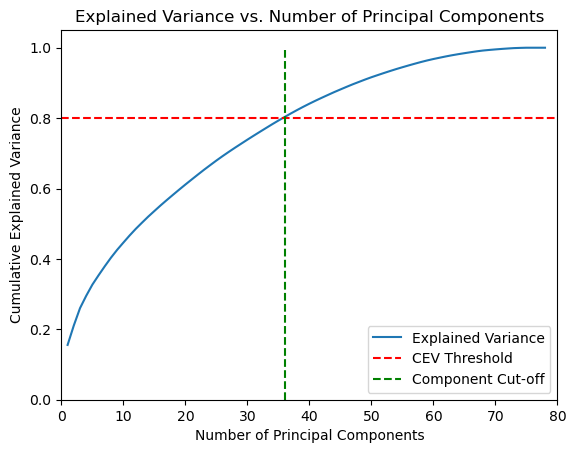

In [46]:
from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=36, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [47]:
#Determine the number of PCA that explain a sufficient proportion of the variance
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [48]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_val_pca = pca_optimal.fit_transform(X_val_scaled)
X_test_pca = pca_optimal.fit_transform(X_test_scaled)

In [49]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(X_train_pca, columns=['PC' + str(i + 1) for i in range(n_components)])
df_principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,2.434794,0.679318,1.673984,-1.013845,1.041514,0.960062,-1.267092,-1.148633,0.623738,1.167381,...,-0.057672,0.769136,0.494502,-0.913773,-0.789422,-0.552911,0.548255,-0.683121,-1.634274,-0.203077
1,-3.282261,-0.557608,-1.479149,-0.952941,-0.563098,2.759115,0.569470,0.681453,-0.223165,0.870144,...,-0.908244,-0.114764,-1.826242,0.501117,-0.337521,-0.585245,-1.068790,0.659815,-0.571012,-1.222340
2,3.240692,-1.633751,1.900720,-1.645978,0.143467,-0.065610,0.027674,-0.198146,0.170393,-0.381261,...,0.495218,0.086622,-0.285649,-0.474843,0.338874,0.116072,-0.105538,0.006845,0.039323,-0.264378
3,-1.099794,0.348176,-1.021587,-0.533689,-0.613642,0.394782,-0.306856,1.149204,-0.909164,-0.001553,...,0.834141,-0.438361,0.449146,0.733823,0.196348,-0.256585,-0.229614,-1.487072,-1.317748,0.194763
4,-0.045695,0.513998,1.552188,0.188375,0.216539,1.503104,-0.048080,0.088176,-0.430927,-0.401809,...,1.308253,-0.650715,-0.828250,0.920426,-0.576368,-0.070326,0.150145,0.178278,0.574159,-1.826298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-1.476124,1.302647,3.138218,-2.394584,0.273695,-2.283237,-0.991543,-1.108791,1.819971,1.847534,...,-0.092320,-4.122975,-0.611221,-0.348934,2.842988,3.963797,-1.421462,1.610391,-0.780756,-2.333604
1740,0.011756,1.777322,-1.110975,-1.303148,-0.207735,0.138195,0.275519,1.170689,-0.056868,-0.428717,...,-0.590668,-0.734626,-0.359756,0.818036,0.267673,-0.041383,0.593636,-3.385169,-0.311906,-0.113036
1741,-4.785570,-0.576927,0.256474,2.446211,-0.467513,-1.259585,0.662818,-1.828311,1.777271,-0.385432,...,0.756503,0.078979,-0.683579,-1.468387,0.769664,-1.762323,-0.292109,-1.005937,1.109944,0.020770
1742,-4.320465,-0.006957,0.575843,3.207738,-0.283391,-2.727267,3.314682,-5.273119,0.241452,-4.050450,...,-2.326983,-1.596822,0.302436,-0.546409,-5.268795,-1.276075,-1.263745,0.749029,-2.087706,-1.366593


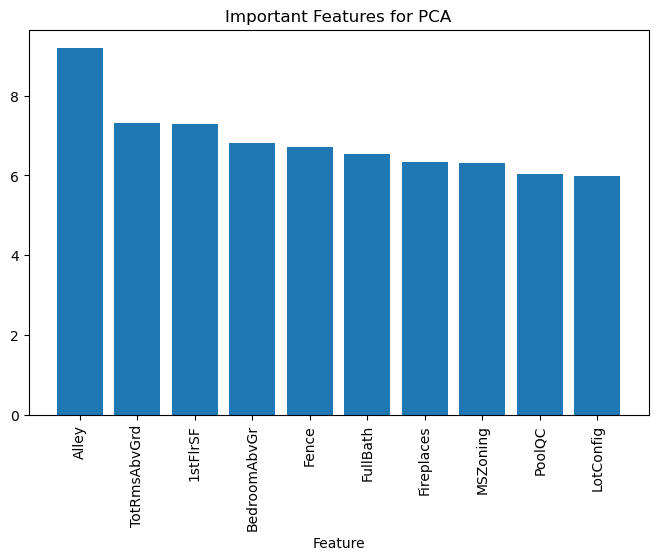

In [50]:
#Important Features for PCA

#Get eigenvectors and eigenvalues
eigenvectors = pca.components_[:, :n_components]
eigenvalues = pca.explained_variance_[:n_components].reshape(-1, 1)

#Calculate feature importance
feature_imp = np.zeros((eigenvectors.shape[0]))
for i in range(0,len(eigenvalues)):
    feature_imp += np.abs(eigenvalues[i] * eigenvectors[:,i])

# Get the indices that would sort the feature_imp in ascending order
sort_ind = np.argsort(feature_imp)

# Select the last 10 indices (corresponding to the largest elements)
largest_feat_ind = sort_ind[-10:]
largest_feat_ind = largest_feat_ind[::-1]  # Reverse order to get largest to smallest

# Get the top 10 elements and their indices
most_imp = feature_imp[largest_feat_ind]

# Get a list of column names corresponding to the selected features
feat_names = list(df_x_encoded.columns[largest_feat_ind])

# Create the bar plot
fig = plt.figure(figsize=(8,5))
plt.bar(range(len(most_imp)), most_imp)
plt.xticks(range(len(feat_names)), feat_names)
plt.xlabel('Feature')
plt.title('Important Features for PCA')
plt.xticks(rotation=90)
plt.show()

## Linear Regression Models

### Linear regression on original data

In [51]:
linear = LinearRegression()
linear.fit(X_train, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, linear.predict(X_test))))

RMSLE:  0.19146627639041264


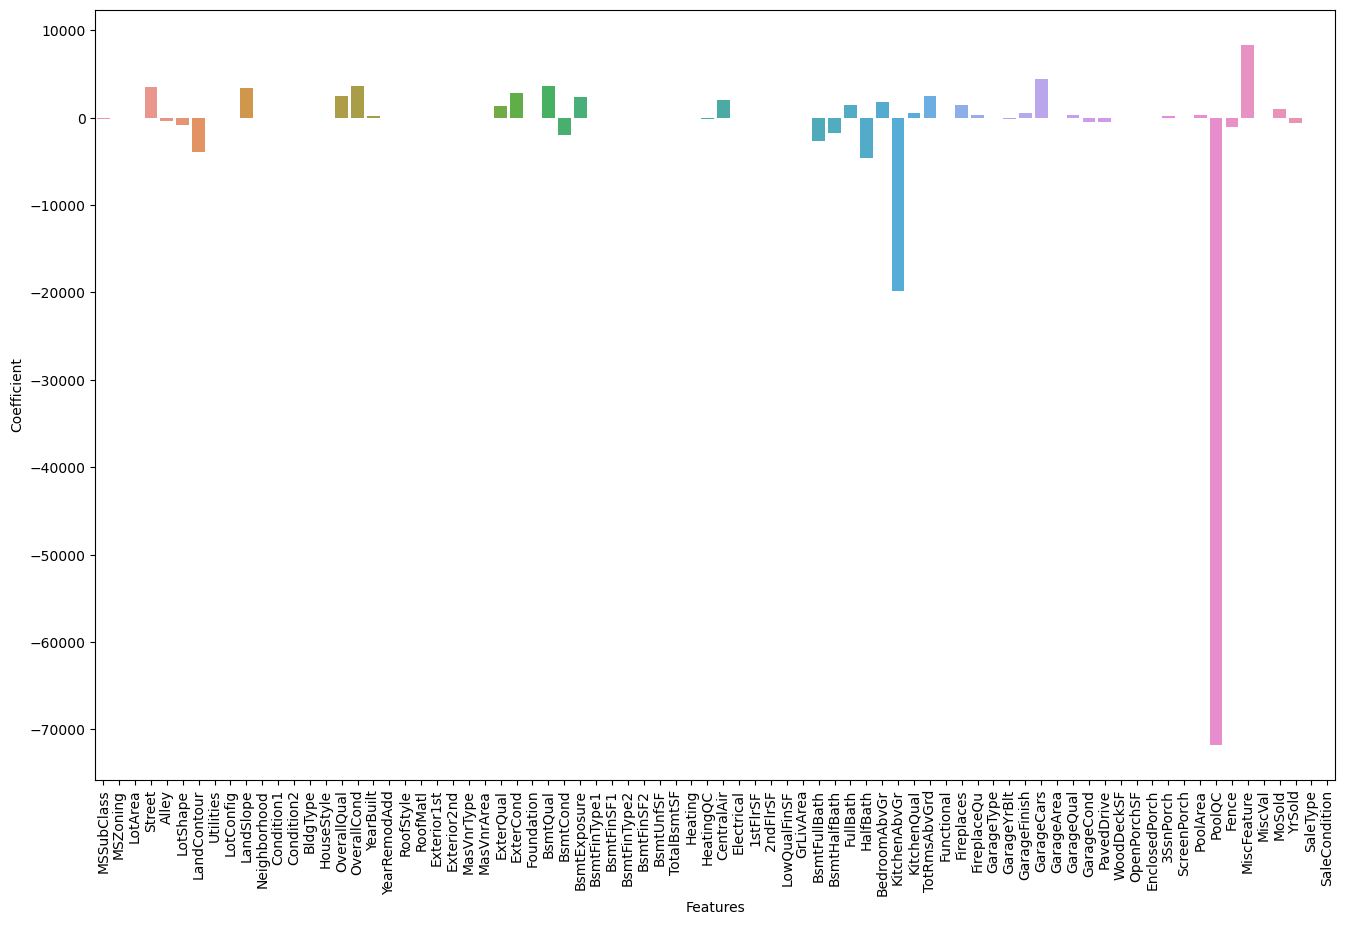

In [52]:
# plot feature importance
fig = plt.figure(figsize=(16,10))
linear_coefs = linear.coef_
names = df_x.columns.to_list()
ax = sns.barplot(x=names, y=linear_coefs)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### LASSO regression on original data

In [53]:
lasso = Lasso(random_state=0)
lasso_alpha = {'alpha': np.logspace(-5, 2, 20)}
grid_search_lasso = GridSearchCV(lasso, lasso_alpha)
grid_search_lasso.fit(X_val, y_val)

print("Best hyperparameters: ", grid_search_lasso.best_params_)

best_lasso = Lasso(alpha=grid_search_lasso.best_params_['alpha'], random_state=0)
best_lasso.fit(X_train, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, best_lasso.predict(X_test))))

Best hyperparameters:  {'alpha': 100.0}
RMSLE:  0.19044585747879805


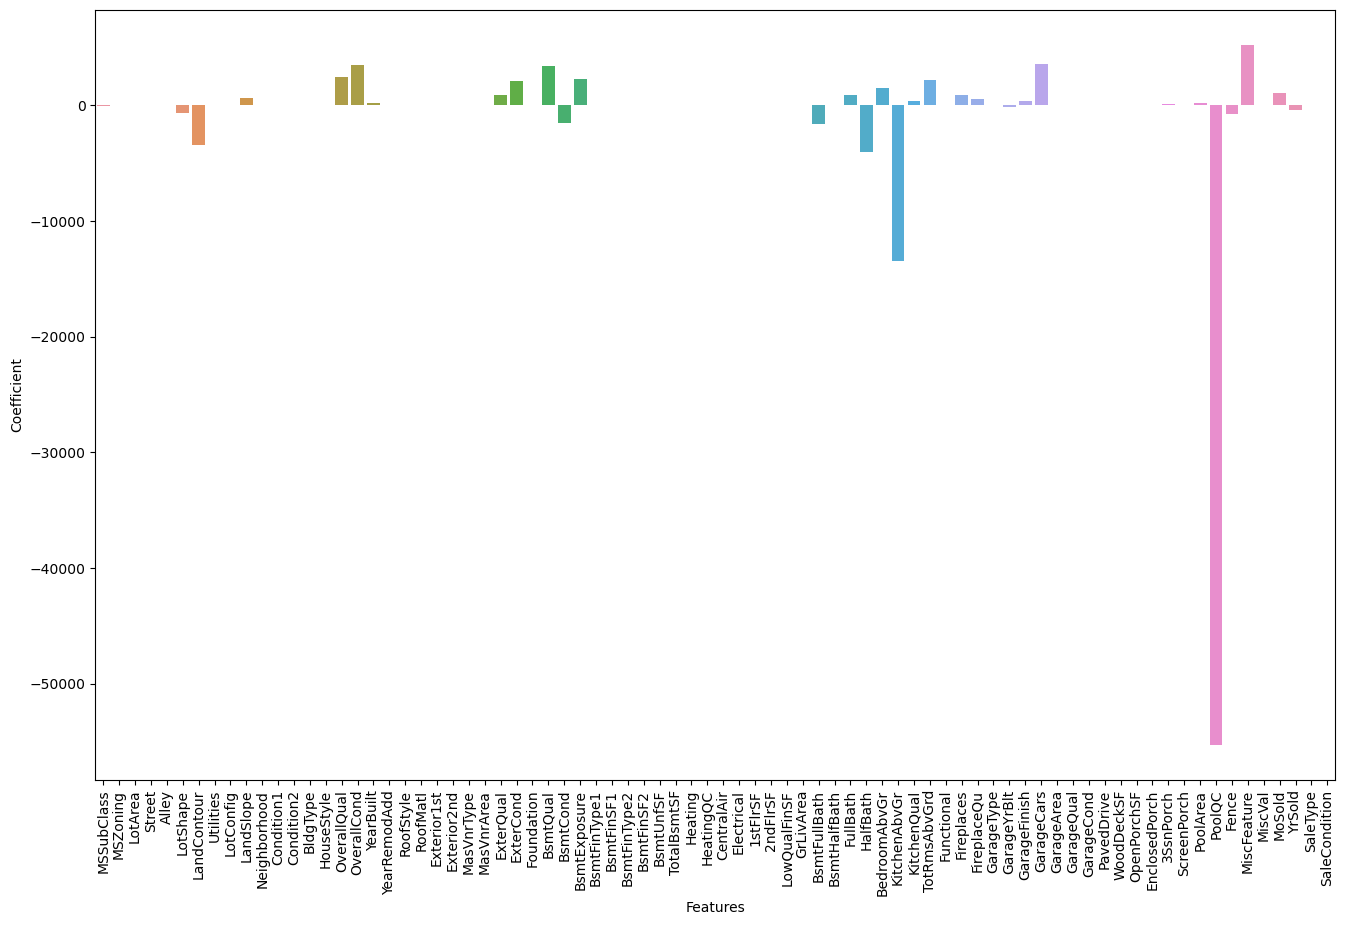

In [54]:
# plot feature importance
fig = plt.figure(figsize= (16,10))
lasso_coefs = best_lasso.coef_  
ax = sns.barplot(x=names, y=lasso_coefs)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### Linear regression using Principal Components

In [55]:
linear_pca = LinearRegression()
linear_pca.fit(X_train_pca, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, linear_pca.predict(X_test_pca))))

RMSLE:  0.3815170708723564


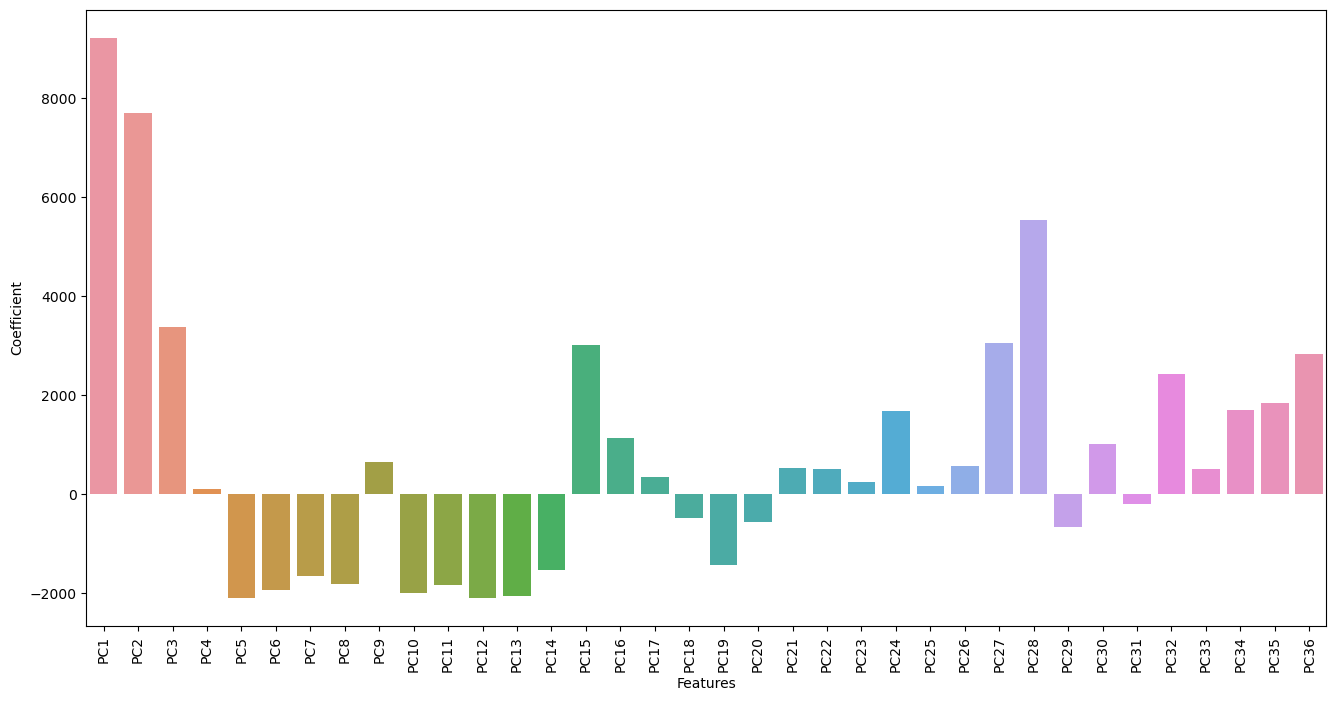

In [56]:
# plot feature importance
fig = plt.figure(figsize= (16,8))
linear_coefs_pca = linear_pca.coef_
names = df_principal_components.columns.to_list()
ax = sns.barplot(x=names, y=linear_coefs_pca)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

### LASSO regression using Principal Components

In [57]:
grid_search_lasso_pca = GridSearchCV(lasso, lasso_alpha)
grid_search_lasso_pca.fit(X_val_pca, y_val)

print("Best hyperparameters: ", grid_search_lasso_pca.best_params_)

best_lasso_pca = Lasso(alpha=grid_search_lasso_pca.best_params_['alpha'], random_state=0)
best_lasso_pca.fit(X_train_pca, y_train)

print("RMSLE: ", np.sqrt(mean_squared_log_error(y_test, best_lasso_pca.predict(X_test_pca))))

Best hyperparameters:  {'alpha': 100.0}
RMSLE:  0.3811328688154213


In [ ]:
# plot feature importance
fig = plt.figure(figsize= (16,8))
lasso_coefs_pca = best_lasso_pca.coef_
names = df_principal_components.columns.to_list()
ax = sns.barplot(x=names, y=lasso_coefs_pca)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.show()

## Tree-Based Models

### Random Forest on original and PCA data

In [22]:
n_estimators = [100, 200, 300, 400, 500]
max_depth = [3, 4, 5, 6, 7]
max_features = ["sqrt", "log2"]

param_combos = []
oob_scores = []
oob_scores_pca = []


for nm in n_estimators:
    for md in max_depth:
        for mf in max_features:
#             print(nm,md,mf)
            param_combos.append(f"{nm},{md},{mf}")
            
            # Build and train random forest model using base data
            rfr = RandomForestRegressor(n_estimators=nm,
                                       max_depth=md,
                                       max_features=mf,
                                       oob_score=True,
                                       warm_start=True)
            rfr.fit(X_train_scaled, y_train)
            
            # Using out-of-bag (OOB) error for finding the optimal hyperparameters
            oob_scores.append(rfr.oob_score_)
            
            del rfr
            
            # Build and train random forest model using PCA data
            rfr_pca = RandomForestRegressor(n_estimators=nm,
                                       max_depth=md,
                                       max_features=mf,
                                       oob_score=True,
                                       warm_start=True)
            rfr_pca.fit(X_train_pca, y_train)
            
            # Using out-of-bag (OOB) error for finding the optimal hyperparameters
            oob_scores_pca.append(rfr_pca.oob_score_)
            
            del rfr_pca
            
# Obtain index for maximum OOB-score
best_index = oob_scores.index(max(oob_scores))
best_index_pca = oob_scores_pca.index(max(oob_scores_pca))

# Obtain the best hyperparameters associated with that index
rfr_best_nm, rfr_best_md, rfr_best_mf = param_combos[best_index].split(',')
rfr_best_nm_pca, rfr_best_md_pca, rfr_best_mf_pca = param_combos[best_index_pca].split(',')

print(param_combos[best_index].split(','))
print(param_combos[best_index_pca].split(','))

['100', '7', 'log2']
['400', '7', 'sqrt']


#### Training Models with Best Hyperparameters

In [23]:
'''
Best hyperparameters:
['300', '7', 'sqrt']
'''

best_rfr = RandomForestRegressor(n_estimators=int(rfr_best_nm),
                                max_depth=int(rfr_best_md),
                                max_features=rfr_best_mf)
best_rfr.fit(X_train_scaled, y_train)
rfr_y_pred = best_rfr.predict(X_test_scaled)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, rfr_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.19945169551641231


In [24]:
'''
Best hyperparameters:
['300', '3', '0.01']
'''

best_rfr_pca = RandomForestRegressor(n_estimators=int(rfr_best_nm_pca),
                                max_depth=int(rfr_best_md_pca),
                                max_features=rfr_best_mf_pca)
best_rfr_pca.fit(X_train_pca, y_train)
rfr_y_pred_pca = best_rfr_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, rfr_y_pred_pca, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.3153782272897327


#### Graph Feature Importances

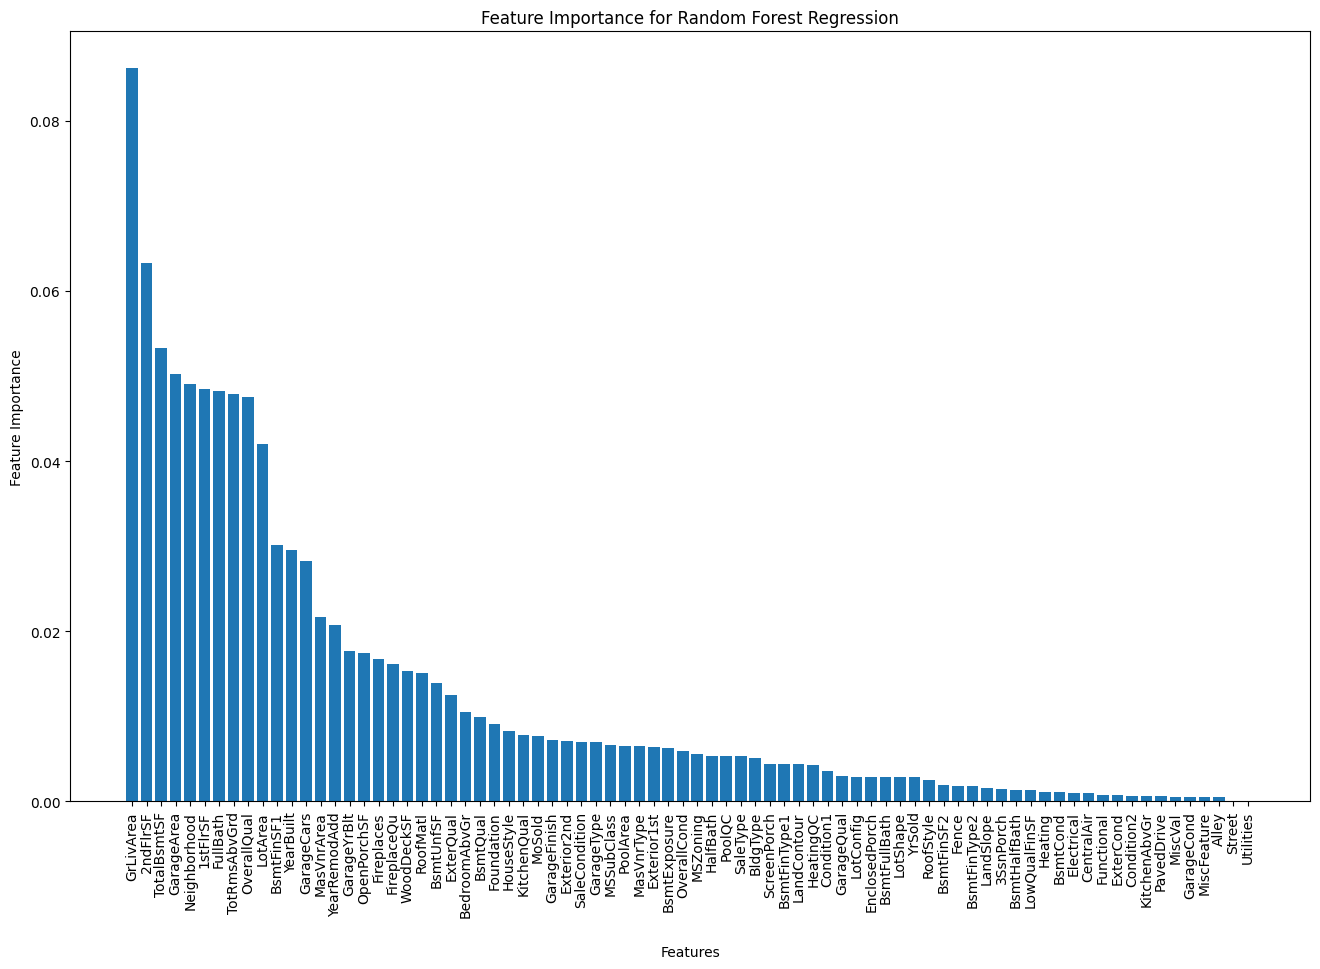

<Figure size 5000x5000 with 0 Axes>

In [25]:
# Organize and sort feature importances in descending order
rfr_tuned_importance = best_rfr.feature_importances_
feature_importance_dict = dict(zip(df_x.columns.to_list(), rfr_tuned_importance))
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Plot the feature importance graph
fig = plt.figure(figsize=(16,10))
plt.bar(sorted_dict.keys(),sorted_dict.values())
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for Random Forest Regression')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

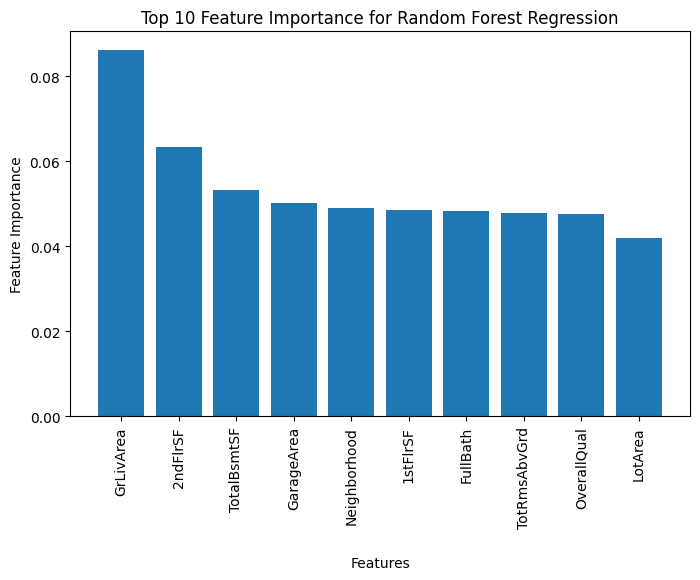

In [26]:
# Organize and sort feature importances in descending order
rfr_tuned_importance = best_rfr.feature_importances_
feature_importance_dict = dict(zip(df_x.columns.to_list(), rfr_tuned_importance))
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)[:10])

# Plot the feature importance graph
fig = plt.figure(figsize=(8,5))
plt.bar(sorted_dict.keys(),sorted_dict.values())
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Top 10 Feature Importance for Random Forest Regression')
plt.xticks(rotation=90)

plt.show()

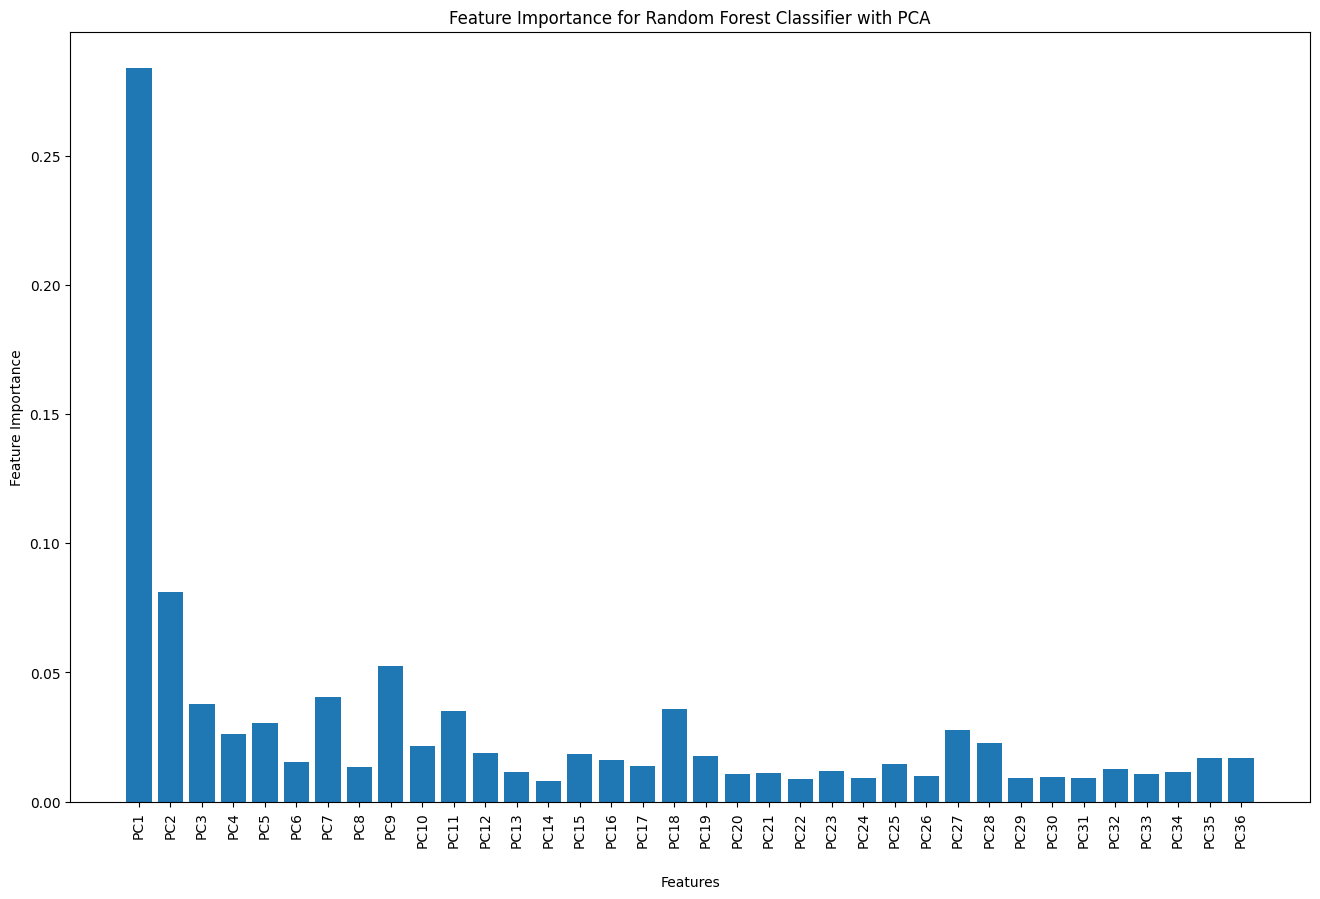

<Figure size 5000x5000 with 0 Axes>

In [27]:
pca_columns=['PC' + str(i + 1) for i in range(n_components)]
rfr_pca_tuned_importance = best_rfr_pca.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,rfr_pca_tuned_importance)
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for Random Forest Classifier with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on original and PCA data

In [28]:
n_estimators = [100, 200, 300, 400, 500]
max_depth = [3, 4, 5, 6, 7]
learning_rate = [0.01, 0.1, 0.5]

param_combos = []
rmsle = []
rmsle_pca = []


for nm in n_estimators:
    for md in max_depth:
        for lr in learning_rate:
#             print(nm,md,lr)
            param_combos.append(f"{nm},{md},{lr}")
            
            # Build XGBoost model for base data
            xgbr = XGBRegressor(n_estimators=nm,
                               max_depth=md,
                               learning_rate=lr)
            xgbr.fit(X_train_scaled, y_train)
            
            # Using validation set and RMSLE for finding the optimal hyperparameters
            xgbr_y_pred = xgbr.predict(X_val_scaled)
            rmsle.append(mean_squared_log_error(y_val, xgbr_y_pred, squared=False))
            
            del xgbr

    
            # Build XGBoost model for PCA data
            xgbr_pca = XGBRegressor(n_estimators=nm,
                               max_depth=md,
                               learning_rate=lr)
            xgbr_pca.fit(X_train_pca, y_train)
            
            # Using validation set and RMSLE for finding the optimal hyperparameters
            xgbr_y_pred_pca = xgbr_pca.predict(X_val_pca)
            rmsle_pca.append(mean_squared_log_error(y_val, xgbr_y_pred_pca, squared=False))
            
            del xgbr_pca
            
            
# Obtain index for minimum RMSLE
best_index = rmsle.index(min(rmsle))
best_index_pca = rmsle_pca.index(min(rmsle_pca))

# Obtain the best hyperparameters associated with that index 
xgbr_best_nm, xgbr_best_md, xgbr_best_mf = param_combos[best_index].split(',')
xgbr_best_nm_pca, xgbr_best_md_pca, xgbr_best_mf_pca = param_combos[best_index_pca].split(',')

print(param_combos[best_index].split(','))
print(param_combos[best_index_pca].split(','))

['200', '3', '0.1']
['300', '3', '0.01']


#### Training Models with Best Hyperparameters

In [29]:
'''
Best hyperparameters:
['200', '3', '0.1']
'''

best_xgbr = XGBRegressor(n_estimators=int(xgbr_best_nm),
                       max_depth=int(xgbr_best_md),
                       learning_rate=xgbr_best_mf)
best_xgbr.fit(X_train_scaled, y_train)
xgbr_best_y_pred = best_xgbr.predict(X_test_scaled)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbr_best_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.2007465337426236


In [30]:
'''
Best hyperparameters:
['300', '3', '0.01']
'''

best_xgbr_pca = XGBRegressor(n_estimators=int(xgbr_best_nm_pca),
                       max_depth=int(xgbr_best_md_pca),
                       learning_rate=xgbr_best_mf_pca)
best_xgbr_pca.fit(X_train_pca, y_train)
xgbr_best_pca_y_pred = best_xgbr_pca.predict(X_test_pca)
print('Root Mean Squared Logarithmic Error (RMSLE):', mean_squared_log_error(y_test, xgbr_best_pca_y_pred, squared=False))

Root Mean Squared Logarithmic Error (RMSLE): 0.3597257488676684


#### Graph Feature Importances

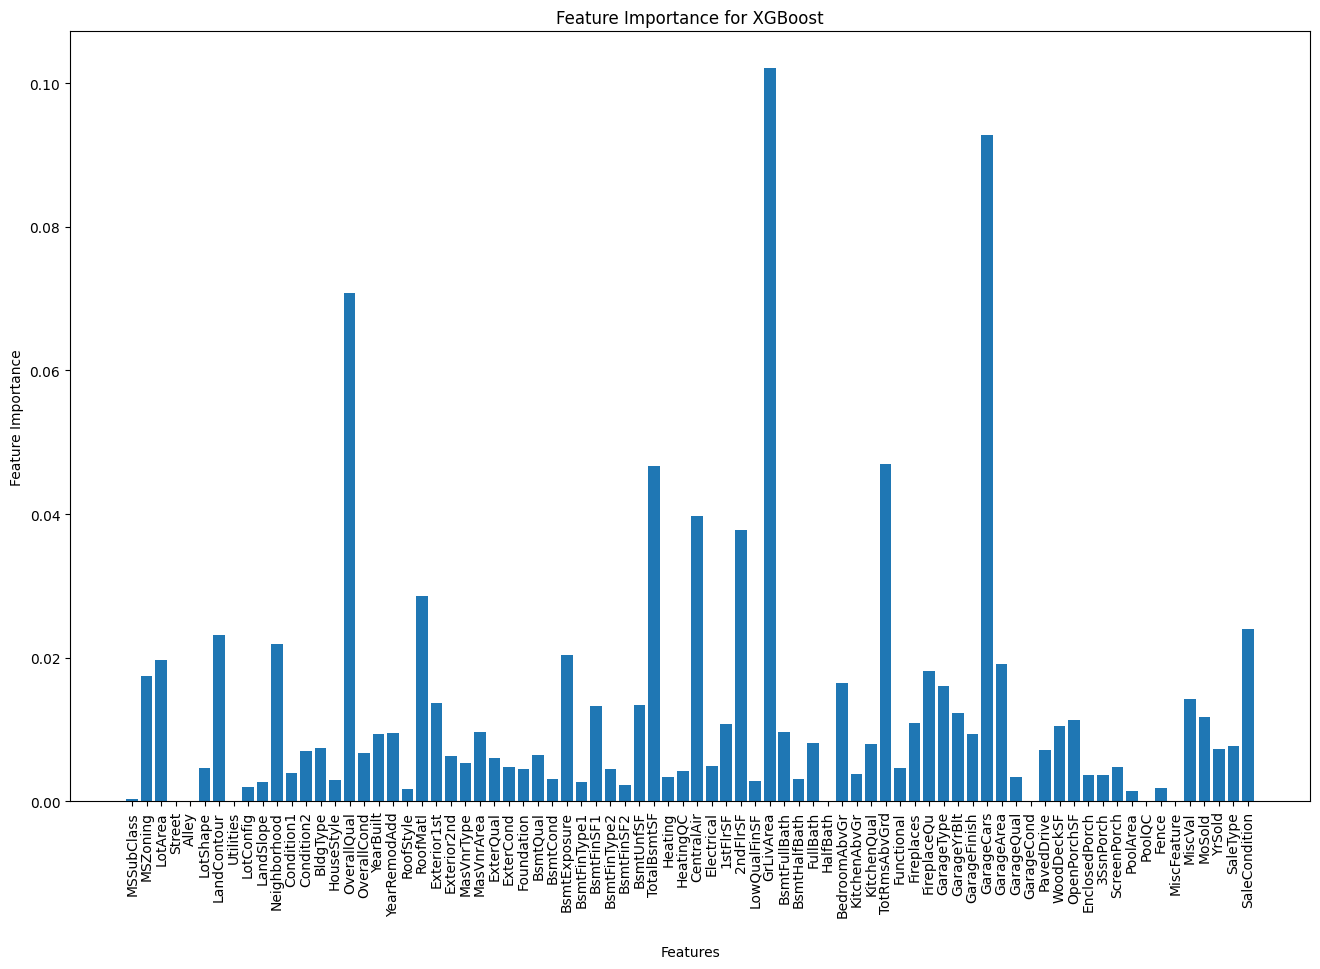

<Figure size 5000x5000 with 0 Axes>

In [31]:
xgb_tuned_importance = best_xgbr.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),xgb_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for XGBoost')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

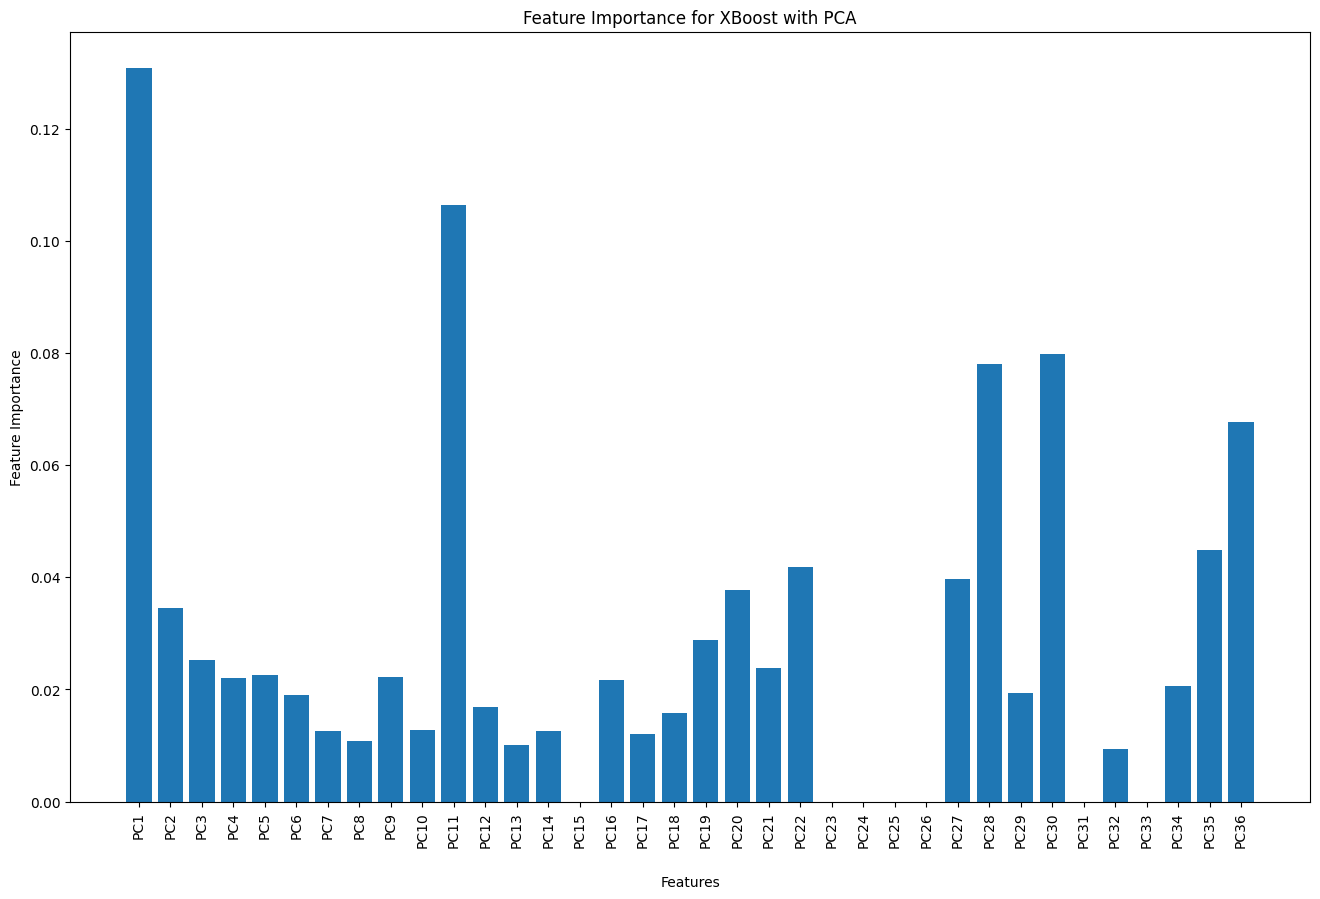

<Figure size 5000x5000 with 0 Axes>

In [32]:
xgb_pca_tuned_importance =best_xgbr_pca.feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,xgb_pca_tuned_importance)
plt.xlabel("Features",labelpad = 20)
plt.ylabel("Feature Importance")
plt.title('Feature Importance for XBoost with PCA')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

## Neural Network Approach

In [33]:
# Define Root Mean Squared Logarithmic Error in TF
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1))))

In [34]:
def build_NN(x_train, reg_param, drop_out, lr, pca):
    
    model = Sequential()
    
    if pca == 0: 
        # The Input Layer :
        model.add(Dense(78, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(reg_param)))

        # The Hidden Layer:
        model.add(Dense(32, kernel_initializer='normal',activation='relu', kernel_regularizer=regularizers.l1(reg_param)))
        model.add(Dropout(drop_out))
        
    if pca == 1:
        model.add(Dense(36, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu', kernel_regularizer=regularizers.l1(reg_param)))

    # Hidden Layers
    model.add(Dense(16, kernel_initializer='normal',activation='relu', kernel_regularizer=regularizers.l1(reg_param)))
    model.add(Dropout(drop_out))
    
    model.add(Dense(8, kernel_initializer='normal',activation='relu', kernel_regularizer=regularizers.l1(reg_param)))
    model.add(Dropout(drop_out))
    
    model.add(Dense(4, kernel_initializer='normal',activation='relu', kernel_regularizer=regularizers.l1(reg_param)))

    # The Output Layer :
    model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    
    #Define Learning Rate of Optimizer
    optimizer = Adam(learning_rate=lr)
    
    #Compile Model
    model.compile(optimizer=optimizer, loss=rmsle, metrics=[rmsle])
    
    return model

In [35]:
# Show example structure
model_example = model = build_NN(X_train, 0, 0, 0, pca=0)
model_example.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 78)                6162      
                                                                 
 dense_1 (Dense)             (None, 32)                2528      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0

2023-04-25 10:51:45.957146: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
# This code takes a long time to run and sometimes yields inconsistent results/errors
# In the next cell are the tuned parameters used for results shown in the report
# They are a combination of results from this grid search tuning approach and manual
# trial and error

# #Hyperparameters
# reg_param = [0, 0.01, 0.001, 0.0001]
# drop_outs = [0, 0.1, 0.2, 0.3]
# lrs = [0.1, 0.01, 0.001, 0.0001, 0.00001]
# epochs = [10, 20, 50, 100]

# best_rmsle = 100
# best_rmsle_pca = 100

# for rp in reg_param:
#     for drop_out in drop_outs:
#         for lr in lrs:
#             for epoch in epochs:

#                 #Model without PCA
                
#                 #Create Model
#                 model = build_NN(X_train, rp, drop_out, lr, 0)

#                 # Train model
#                 model.fit(X_train, y_train, epochs=epoch, verbose=0)

#                 # Evaluate model
#                 val_loss, val_rmsle = model.evaluate(X_val, y_val)

#                 if val_rmsle < best_rmsle:

#                     best_reg = rp
#                     best_do = drop_out
#                     best_lr = lr
#                     best_epoch = epoch

#                     best_rmsle = val_rmsle

#                 del model
#                 del val_rmsle

#                 #Model with PCA
                
#                 #Create Model
#                 model = build_NN(X_train_pca, rp, drop_out, lr, 1)

#                 # Train your model
#                 model.fit(X_train_pca, y_train, epochs=epoch, verbose=0)

#                 # Evaluate your model using RMSLE
#                 val_loss, val_rmsle = model.evaluate(X_val_pca, y_val)

#                 if val_rmsle < best_rmsle_pca:
                    
#                     best_reg_pca = rp
#                     best_do_pca = drop_out
#                     best_lr_pca = lr
#                     best_epoch = epoch

#                     best_rmsle_pca = val_rmsle

#                 del model
#                 del val_rmsle

In [37]:
# Best Parameters for Hyperparameter Tuning (model without PCA)
reg_param = 0.0001
drop_out = 0.1
learning_rate = 0.01
epoch = 10

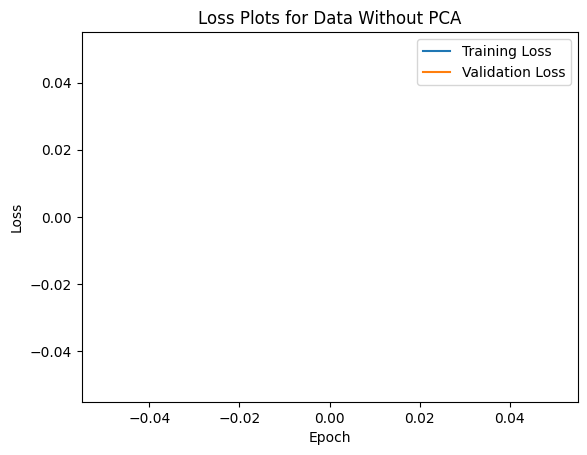

18/18 [==============================] - 0s 2ms/step - loss: nan - rmsle: nan


In [38]:
model1 = build_NN(X_train, reg_param, drop_out, learning_rate, 0)

# Train your model and store the history object
history = model1.fit(X_train, y_train, epochs=epoch, verbose=0, validation_data=(X_val, y_val))

# Get the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss as a function of epoch
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plots for Data Without PCA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_rmsle = model1.evaluate(X_test, y_test)

In [39]:
# Best Parameters for Hyperparameter Tuning (model with PCA)
reg_param = 0.01
drop_out = 0.2
learning_rate = 0.01
epoch = 20

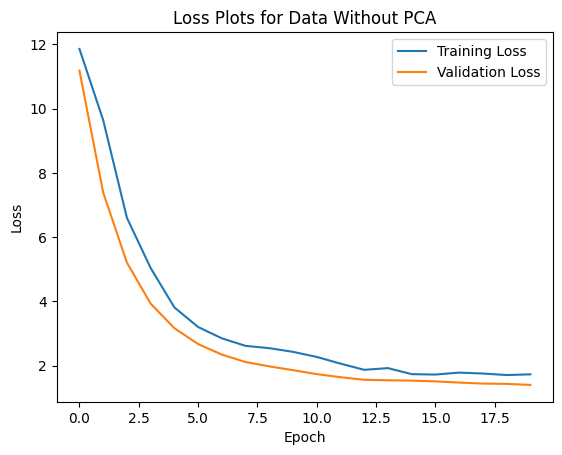

18/18 [==============================] - 0s 2ms/step - loss: 1.2987 - rmsle: 0.2978


In [40]:
model2 = build_NN(X_train_pca, reg_param, drop_out, learning_rate, 1)

# Train your model and store the history object
history = model2.fit(X_train_pca, y_train, epochs=epoch, verbose=0, validation_data=(X_val_pca, y_val))

# Get the training and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss as a function of epoch
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plots for Data Without PCA')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_rmsle = model2.evaluate(X_test_pca, y_test)

## Group-Specific 

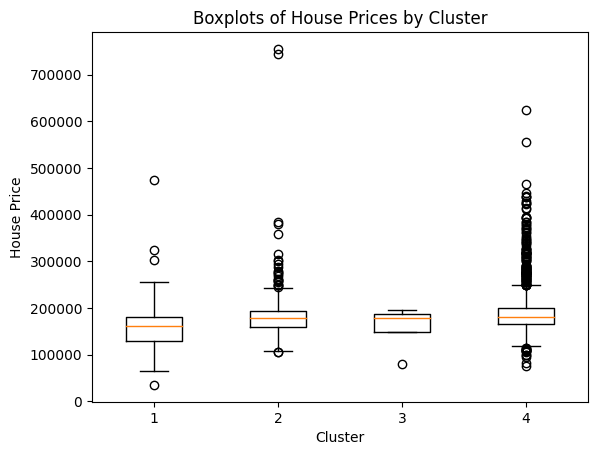

Cluster 1: 393 data points
Cluster 2: 349 data points
Cluster 3: 5 data points
Cluster 4: 997 data points


In [41]:
from sklearn.mixture import GaussianMixture

#Gaussian Mixture Modelling
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X_train_scaled)

# Predict the labels for the data
labels = gmm.predict(X_train_scaled)

# Create a list of y values for each cluster
y_cluster = [y_train[labels == i] for i in range(gmm.n_components)]

# Sort clusters in ascending order (by median)
sorted_y_cluster = sorted(y_cluster, key=lambda x: np.median(x))

# Boxplot of clusters
plt.boxplot(sorted_y_cluster)
plt.title("Boxplots of House Prices by Cluster")
plt.xlabel("Cluster")
plt.ylabel("House Price")
plt.show()

# Count number of points in each cluster
for i in range(0,len(sorted_y_cluster)):
    print("Cluster " + str(i+1) + ": " + str(len(sorted_y_cluster[i])) + " data points")  

In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import numpy as np

# Initialize a list to store the RMSLE for each cluster-specific model
rmsle_list = []

# Loop through each cluster
for i in range(gmm.n_components):
    # Get the indices of the samples belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]

    # Split the data into training and testing sets for the current cluster
    X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
        X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

    # Train a linear regression model for the current cluster
    linear_cluster = LinearRegression()
    linear_cluster.fit(X_cluster_train, y_cluster_train)

    # Calculate the RMSLE for the current cluster-specific model
    y_pred = linear_cluster.predict(X_cluster_test)
    y_pred_clipped = np.clip(y_pred, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

    rmsle_list.append(rmsle)
    print(f"Cluster {i+1} RMSLE: {rmsle}")

# Calculate the average RMSLE across all cluster-specific models
average_rmsle = np.mean(rmsle_list)
print(f"Average RMSLE for cluster-specific models: {average_rmsle}")

# Compare the average RMSLE with the baseline RMSLE
baseline_rmsle = np.sqrt(mean_squared_log_error(y_test, linear.predict(X_test)))
print(f"Baseline RMSLE: {baseline_rmsle}")

Cluster 1 RMSLE: 0.2613436844188014
Cluster 2 RMSLE: 0.1864920932415385
Cluster 3 RMSLE: 0.2136397395189924
Cluster 4 RMSLE: 1.4615654210676097
Average RMSLE for cluster-specific models: 0.5307602345617355


NameError: name 'linear' is not defined

Based on the results you provided, the cluster-specific linear regression models have a higher average RMSLE (0.5308) compared to the baseline linear regression model (0.1915). This indicates that the group-specific regression for each cluster found in the GMM does not enhance the performance compared to the linear regression on the original data in this case.

One possible reason for this outcome is that the GMM clustering is not effectively capturing the underlying structure of the data in a way that benefits the prediction of house prices. Another reason could be the presence of a cluster with a particularly high RMSLE (Cluster 4) which is skewing the average RMSLE upwards. You could try experimenting with different clustering techniques or varying the number of clusters to see if you can obtain better results.

In [ ]:
# Initialize a list to store the RMSLE for each cluster-specific model
rmsle_list = []

# Loop through each cluster, excluding Cluster 4
for i in range(gmm.n_components - 1):  # Change the loop range to exclude the last cluster
    # Get the indices of the samples belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]

    # Split the data into training and testing sets for the current cluster
    X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
        X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

    # Train a linear regression model for the current cluster
    linear_cluster = LinearRegression()
    linear_cluster.fit(X_cluster_train, y_cluster_train)

    # Calculate the RMSLE for the current cluster-specific model
    y_pred = linear_cluster.predict(X_cluster_test)
    y_pred_clipped = np.clip(y_pred, 0, None)
    rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

    rmsle_list.append(rmsle)
    print(f"Cluster {i+1} RMSLE: {rmsle}")

# Calculate the average RMSLE across all cluster-specific models, excluding Cluster 4
average_rmsle_without_cluster4 = np.mean(rmsle_list)
print(f"Average RMSLE for cluster-specific models without Cluster 4: {average_rmsle_without_cluster4}")

# Compare the average RMSLE without Cluster 4 with the baseline RMSLE
print(f"Baseline RMSLE: {baseline_rmsle}")


Based on the updated results without Cluster 4, the average RMSLE for the cluster-specific linear regression models is 0.2205, which is still higher than the baseline RMSLE of 0.1915. This indicates that even without considering Cluster 4, the group-specific regression for each cluster found in the GMM does not enhance the performance compared to the linear regression on the original data.

This could be because the GMM clustering is still not effectively capturing the underlying structure of the data in a way that benefits the prediction of house prices. It may be worth exploring other clustering techniques, varying the number of clusters, or even trying different regression algorithms to see if you can obtain better results.

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define clustering algorithms with their specific parameters
clustering_algorithms = {
    'KMeans': {'algorithm': KMeans, 'params': {'n_clusters': None, 'random_state': 42}},
    'AgglomerativeClustering': {'algorithm': AgglomerativeClustering, 'params': {'n_clusters': None}},
    'GaussianMixture': {'algorithm': GaussianMixture, 'params': {'n_components': None, 'random_state': 42}}
}

# Define regression algorithms
regression_algorithms = {
    'LinearRegression': LinearRegression,
    'LASSO': Lasso,
    'RandomForestRegressor': RandomForestRegressor,
    'XGBoost': XGBRegressor,
    'NeuralNetworkRegressor': MLPRegressor
}

# Define the range of the number of clusters to explore
n_clusters_range = range(2, 8)

# Initialize variables to store the best model information
best_rmsle = float('inf')
best_clustering = None
best_n_clusters = None
best_regression = None

# Loop through each clustering algorithm
for clustering_name, clustering_info in clustering_algorithms.items():
    # Loop through the range of the number of clusters
    for n_clusters in n_clusters_range:
        # Set the appropriate parameter for the number of clusters or components
        if clustering_name == 'GaussianMixture':
            clustering_info['params']['n_components'] = n_clusters
        else:
            clustering_info['params']['n_clusters'] = n_clusters

        # Initialize the clustering algorithm with the current number of clusters and specific parameters
        clustering = clustering_info['algorithm'](**clustering_info['params'])

        # Fit the clustering algorithm to the training data and predict the labels
        if clustering_name == 'GaussianMixture':
            clustering.fit(X_train_scaled)
            labels = clustering.predict(X_train_scaled)
        else:
            labels = clustering.fit_predict(X_train_scaled)
        
        # Calculate the silhouette score for the current clustering
        silhouette_avg = silhouette_score(X_train_scaled, labels)
        
        # Loop through each regression algorithm
        for regression_name, Regression in regression_algorithms.items():
            # Initialize a list to store the RMSLE for each cluster-specific model
            rmsle_list = []
            
            # Loop through each cluster
            for i in range(n_clusters):
                # Get the indices of the samples belonging to the current cluster
                cluster_indices = np.where(labels == i)[0]

                # Split the data into training and testing sets for the current cluster
                X_cluster_train, X_cluster_test, y_cluster_train, y_cluster_test = train_test_split(
                    X_train.iloc[cluster_indices], y_train.iloc[cluster_indices], test_size=0.2, random_state=42)

                # Train a regression model for the current cluster
                regression = Regression()
                regression.fit(X_cluster_train, y_cluster_train)

                # Calculate the RMSLE for the current cluster-specific model
                y_pred = regression.predict(X_cluster_test)
                y_pred_clipped = np.clip(y_pred, 0, None)
                rmsle = np.sqrt(mean_squared_log_error(y_cluster_test, y_pred_clipped))

                rmsle_list.append(rmsle)

            # Calculate the average RMSLE across all cluster-specific models
            average_rmsle = np.mean(rmsle_list)
            
            # Update the best model information if the current combination has a lower average RMSLE
            if average_rmsle < best_rmsle:
                best_rmsle = average_rmsle
                best_clustering = clustering_name
                best_n_clusters = n_clusters
                best_regression = regression_name

            print(f"{clustering_name} with {n_clusters} clusters and {regression_name}: Average RMSLE = {average_rmsle:.4f}, Silhouette Score = {silhouette_avg:.4f}")

# Print the best model information
print(f"\nBest combination: {best_clustering} with {best_n_clusters} clusters and {best_regression}")
print(f"Best average RMSLE: {best_rmsle:.4f}")
